<a href="https://colab.research.google.com/github/samuel-c-santos/s2dr3_inferencia_automatizada_sentinel2/blob/main/s2dr3_inferencia_automatizada_sentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌍 S2DR3 - Super-resolução de Imagens Sentinel-2

Este notebook demonstra o uso do modelo **S2DR3** para gerar imagens super-resolvidas de cenas Sentinel-2, com resolução final de **1 metro por pixel**.

As imagens de entrada são selecionadas automaticamente via **Google Earth Engine (GEE)**, priorizando aquelas com **menor cobertura de nuvens**.

O produto final inclui imagens multiespectrais e derivadas, salvas no diretório `/content/output`.

> Para mais informações sobre o modelo e a metodologia, consulte o [README.md](./README.md).

---

### 📋 Estrutura do notebook:
- Instalação de dependências
- Seleção automática da melhor imagem
- Aplicação do modelo S2DR3
- Download dos resultados em GeoTIFF

#Instalação de dependências

In [ ]:
# Certifique-se de selecionar a instância com GPU T4 no menu Executar > Alterar tipo de tempo de execução
# OPCIONAL: Para vincular seu Google Drive e salvar os arquivos de saída, descomente e modifique a linha abaixo
#!ln -s /content/drive/MyDrive/{CAMINHO_PARA_ARQUIVOS_DE_SAIDA} /content/output

# Instala o GDAL (utilitário para manipulação de dados geoespaciais)
!apt install -qq gdal-bin

# Instala o pacote S2DR3 a partir de um link direto (pré-compilado para Python 3.11 e Linux)
!pip -q install https://storage.googleapis.com/0x7ff601307fa5/s2dr3-20250307.1-cp311-cp311-linux_x86_64.whl

#Seleção automática da melhor imagem

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-samuelsantosambientalcourse')

# Coordenadas do ponto (WGS84)
lon, lat = -48.4443399, -1.4248187
point = ee.Geometry.Point([lon, lat])

# Coleção Sentinel-2 filtrada
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(point)
    .filterDate('2024-8-01', '2025-04-24')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Limite de nuvem
    .sort('CLOUDY_PIXEL_PERCENTAGE')
)

# Verifica o número de imagens disponíveis ANTES de aplicar .toList()
n_images = collection.size().getInfo()

if n_images == 0:
    raise ValueError("Nenhuma imagem encontrada com menos de 10% de nuvem no intervalo especificado.")

# Se houver imagens, pega a primeira e extrai a data
image = ee.Image(collection.first())
date = image.date().format('YYYY-MM-dd').getInfo()
print("Melhor data encontrada:", date)


Melhor data encontrada: 2024-09-11


#Limpar saídas anteriores

In [ ]:
#limpar o output
import shutil
import os

# Apaga o conteúdo antigo da pasta de saída
output_dir = '/content/output'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

print("Pasta de saída limpa!")


Pasta de saída limpa!


#Aplicação do modelo S2DR3

Iniciando inferência para (-48.4443399, -1.4248187) na data 2024-09-11...
Fetching data for T22MGD-c55b89599-20240911 .......... done. 
Processing S2L2A_T22MGD-c55b89599-20240911_MS . done 
Postprocessing S2L2A_T22MGD-c55b89599-20240911_MS ......... done

Find results at the following path: /content/output
Click the link below for preview:

https://gamayos.github.io/gamma-earth-api/s2dr3-demo-20250305.html?ds=BR-T22MGD-c55b89599-20240911#15/-1.4248/-48.4443



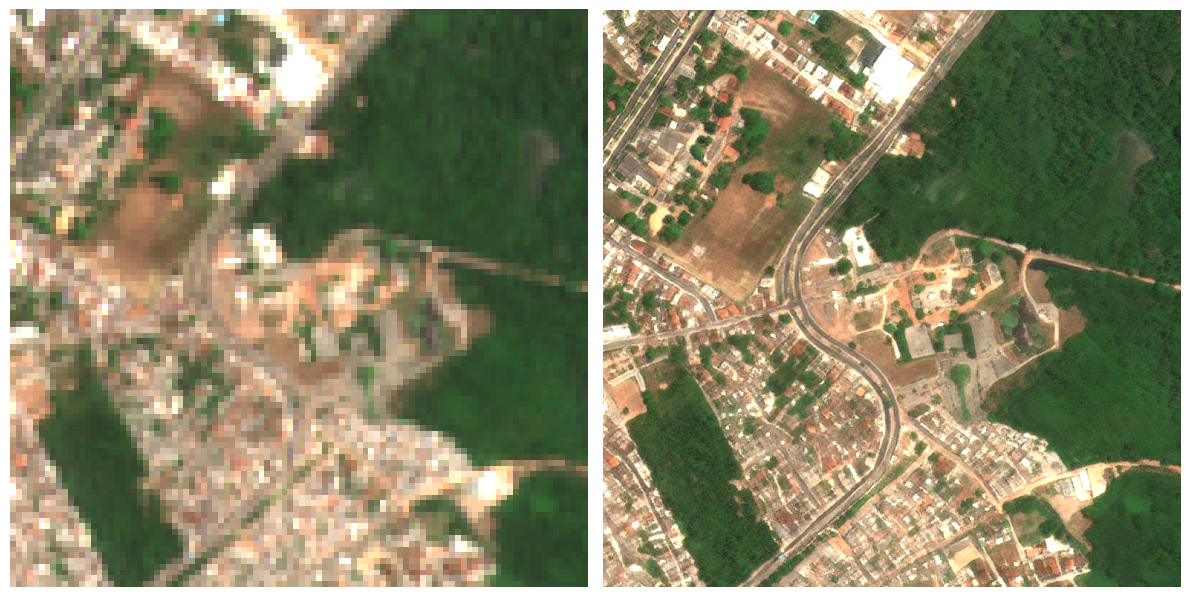

In [ ]:
import s2dr3.inferutils

# Especifica a localização-alvo no formato (longitude, latitude)
lonlat = (-48.4443399, -1.4248187)

# Usa a variável 'date' definida anteriormente com base na menor cobertura de nuvens
# A imagem processada terá resolução de 1 metro e abrangerá uma área de 4x4 km

print(f"Iniciando inferência para {lonlat} na data {date}...")
s2dr3.inferutils.test(lonlat, date)

#Download dos resultados em GeoTIFF

In [ ]:
import os
from google.colab import files

# Caminho de saída padrão do modelo
output_dir = '/content/output'

# Lista todos os arquivos .tif gerados
tif_files = [f for f in os.listdir(output_dir) if f.endswith('.tif')]

# Baixa cada arquivo
for filename in tif_files:
    file_path = os.path.join(output_dir, filename)
    print(f"Baixando: {filename}")
    files.download(file_path)